In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from datetime import timedelta
import math

# sklearn models and evaluators
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# for graphing
import plotly.express as px

import datetime

## Preprocessing

In [2]:
df = pd.read_csv("loan_data.csv")
model_data = df[df.columns]

# convert to datetime for date calculations
model_data[['repaymentDate', 'loanRepaidDate', 'loanCreatedAt']] = model_data[['repaymentDate', 'loanRepaidDate', 'loanCreatedAt']].apply(pd.to_datetime)

# create column for the number of days it took to repay the loan
model_data['paybackDuration'] = (model_data["loanRepaidDate"] - model_data["loanCreatedAt"]).dt.days

# create col for the number of days it was overdue (negative numbers means it was paid on time)
model_data['daysOverdue'] = ((model_data['repaymentDate'] - model_data["loanRepaidDate"]) * -1)

# check to make sure im not crazy and some loan creation dates are before the repayment date
model_data['sanityCheck'] = (model_data['loanCreatedAt'] - model_data["repaymentDate"])

# fix NaN values
model_data[['paybackDuration', 'daysOverdue']] = model_data[['paybackDuration', 'daysOverdue']].fillna(pd.Timedelta(days=0))

# convert to int64 for label condition
# model_data['daysOverdue'] = (model_data['daysOverdue'].astype('int64') / 86400)
model_data['interestPercent'] = (model_data['interestOnLoan'] / model_data['loanAmount']) * 100

# # create labels for supervised learning, >14 days overdue is a default(NOT DEFAULT: 0, DEFAULT: 1)
# model_data.loc[model_data['daysOverdue'] < timedelta(14), 'target'] = 0
# model_data.loc[model_data['daysOverdue'] >= timedelta(14), 'target'] = 1

model_data['daysOverdue'] = (model_data['daysOverdue'].dt.days).astype(float)
model_data['sanityCheck'] = (model_data['sanityCheck'].dt.days).astype(float)

# model_data[(model_data['sanityCheck'].astype('int64') / 86400)>0].to_json("loan_dates_misalignment.json")
# model_data = model_data.groupby('interestPercent')
# model_data.describe()
# model_data = model_data.groupby(['customerId', 'loanAmount'])[['daysOverdue', 'interestPercent', 'location', 'educationLevel']]
# model_data[model_data['target'] == 1]



In [3]:
# features to use in the nn
quant_features = ['customerAge', 'loanAmount', 'daysOverdue', 'interestPercent']
qual_features = ['maritalStatus', 'educationLevel', 'location']

# drop unused columns
model_data = model_data.drop(columns=['location', 'sanityCheck', 'customerId', 'repaymentDate', 'loanRepaidDate', 'loanCreatedAt', 'paybackDuration'])

# keep for distribution comparisons
old_model_data = model_data.copy()

In [4]:
# fix skewed data with log() and sqrt()
model_data[['loanAmount', 'customerAge', 'interestOnLoan']] = np.log(model_data[['loanAmount', 'customerAge', 'interestOnLoan']])

model_data['interestPercent'] = np.sqrt(model_data['interestPercent'])


<ipython-input-4-52e102c7650e>:2: RuntimeWarning: divide by zero encountered in log
  model_data[['loanAmount', 'customerAge', 'interestOnLoan']] = np.log(model_data[['loanAmount', 'customerAge', 'interestOnLoan']])


In [5]:
# add categorical encodings and set types
model_data['loanStatus'] = model_data['loanStatus'].astype('string')
model_data[['maritalStatus', 'educationLevel']] = model_data[['maritalStatus', 'educationLevel']].astype('category')
model_data['maritalStatus'] = model_data['maritalStatus'].cat.codes.astype('float64')
model_data['educationLevel'] = model_data['educationLevel'].cat.codes.astype('float64')

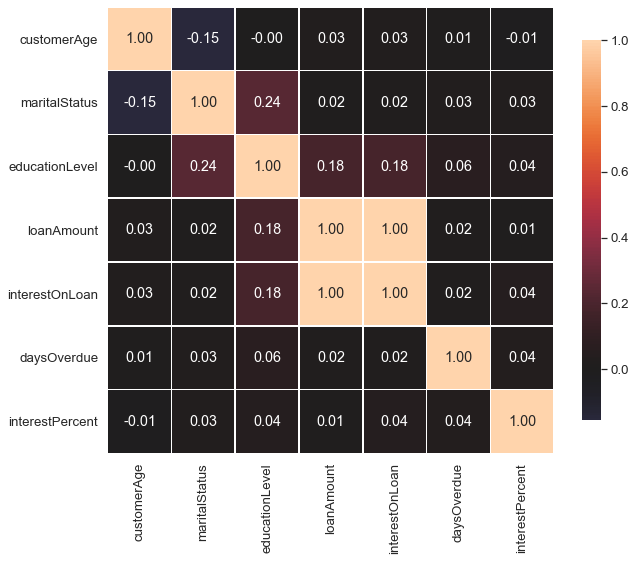

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# spearman correlation for checking for redundancy
def correlation_heatmap(data):
	correlations = data.corr()
	sns.set(font_scale=1.2)
	fig, ax = plt.subplots(figsize=(10, 10))
	sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
				square=True, linewidths=.5, annot=True, cbar_kws={"shrink":.70})
	plt.show();
correlation_heatmap(model_data)

In [7]:
# drop interest on loan because spearman correlation shows its redundant
model_data = model_data.drop(columns=['interestOnLoan'])

In [8]:
# remove the target from the feature set
features = model_data.iloc[:, model_data.columns != 'loanStatus']

# clean the dataset of NaN and infinity
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
model_data = pd.merge(clean_dataset(features), model_data['loanStatus'], left_index=True, right_index=True)


<ipython-input-8-38802a96381b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [9]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from imblearn.over_sampling import ADASYN

# create synthetic data to fix the current 97:3 target ratio
features = model_data.iloc[:, model_data.columns != 'loanStatus']
labels = model_data['loanStatus']
def makeOverSamplesADASYN(features,labels):
	sm = ADASYN()
	X, y = sm.fit_resample(features, labels)
	return(X,y)

X, y = makeOverSamplesADASYN(features, labels)


## Distribution Analysis

In [10]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

for col in X.columns:
	fig = make_subplots(rows=1, cols=2)
	trace1 = go.Histogram(x=old_model_data[col])
	trace2 = go.Histogram(x=X[col])
	fig.append_trace(trace1, row=1, col=1)
	fig.append_trace(trace2, row=1, col=2)
	fig.update_layout(title_text=str(col))
	fig.show()  


## Models

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:

	dfs = []
	# list the models to test
	models = [
			('LogReg', LogisticRegression()), 
			('RF', RandomForestClassifier()),
			('SVM', SVC()), 
			('GNB', GaussianNB()),
			('XGB', XGBClassifier())
			]
	results = []
	names = []
	scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
	target_names = ['Default', 'Not Default']

	# run kfold cv and various eval functions on the data for each model
	for name, model in models:
		kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
		cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
		clf = model.fit(X_train, y_train)
		y_pred = clf.predict(X_test)
		print(name)
		print(classification_report(y_test, y_pred, target_names=target_names))
		print("Confusion Matrix:")
		print(confusion_matrix(y_test, y_pred))
		results.append(cv_results)
		names.append(name)
		this_df = pd.DataFrame(cv_results)
		this_df['model'] = name
		dfs.append(this_df)
		
	final = pd.concat(dfs, ignore_index=True)
	return final

final = run_exps(X_train, y_train, X_test, y_test)

LogReg
              precision    recall  f1-score   support

     Default       0.60      0.57      0.58       781
 Not Default       0.56      0.59      0.58       727

    accuracy                           0.58      1508
   macro avg       0.58      0.58      0.58      1508
weighted avg       0.58      0.58      0.58      1508

Confusion Matrix:
[[442 339]
 [296 431]]
RF
              precision    recall  f1-score   support

     Default       0.96      0.97      0.96       781
 Not Default       0.96      0.95      0.96       727

    accuracy                           0.96      1508
   macro avg       0.96      0.96      0.96      1508
weighted avg       0.96      0.96      0.96      1508

Confusion Matrix:
[[755  26]
 [ 34 693]]
SVM
              precision    recall  f1-score   support

     Default       0.64      0.97      0.77       781
 Not Default       0.92      0.42      0.58       727

    accuracy                           0.70      1508
   macro avg       0.78      0.6

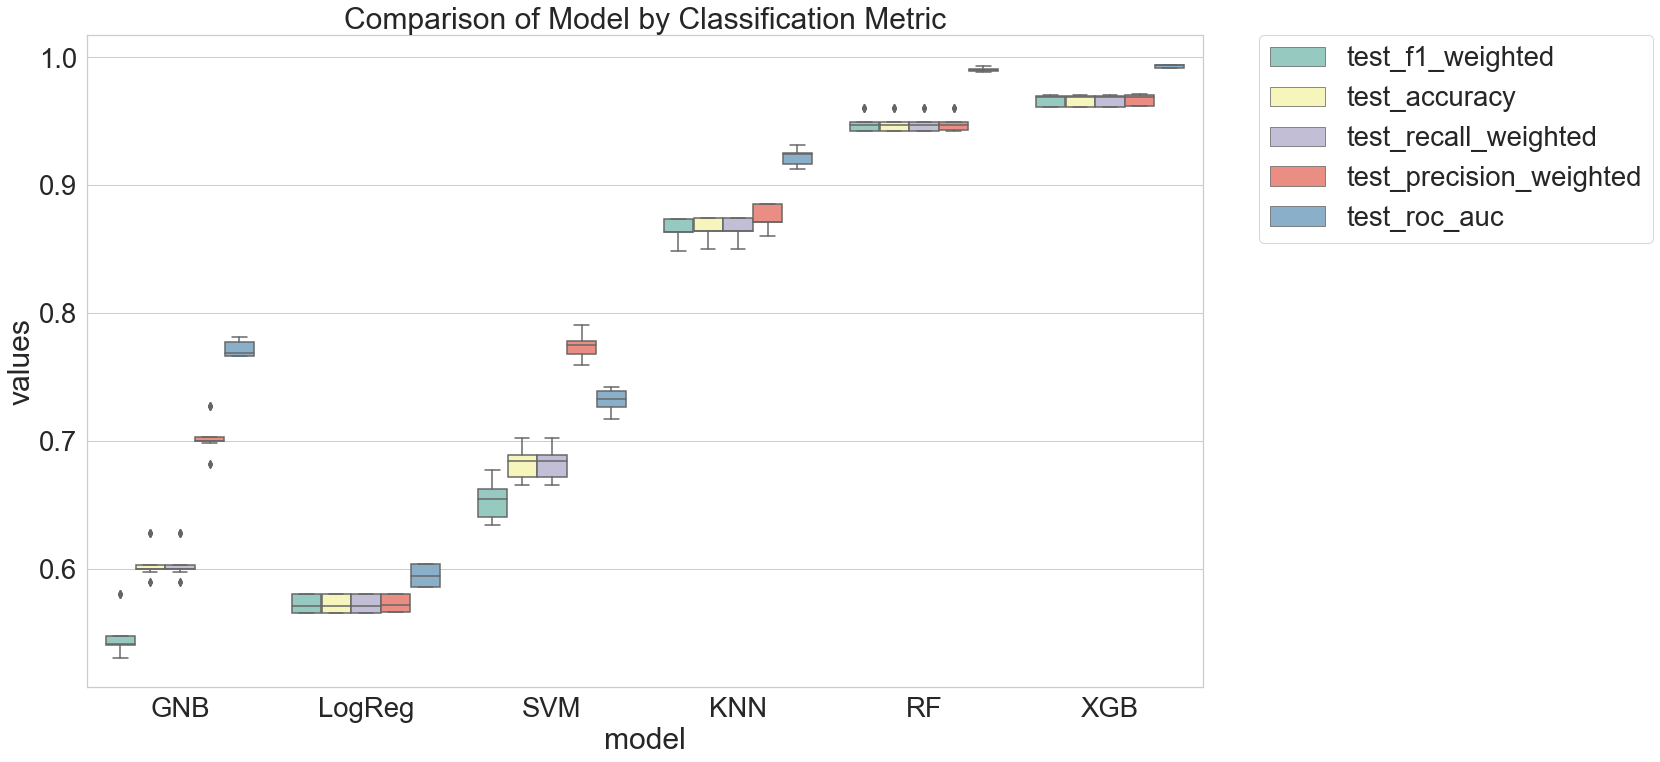

In [235]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
sns.set_style("whitegrid")
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)